In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.examples.tutorials.mnist import input_data
#For binarizing the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder() 
lb = preprocessing.LabelBinarizer()

#importing the Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]


# HELPER FUNCTIONS

def shuffle(data, target):
    index = np.arange(0, len(data))
    np.random.shuffle(index)
    shuffled_data = [data[i] for i in index]
    shuffled_target = [target[i] for i in index]
    return np.asarray(shuffled_data), np.asarray(shuffled_target)

#Hyperparameters
learning_rate = 0.005
batch_size = 20
n_epoch = 1000
max_no_progress = 20

In [2]:
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
lb.fit(y_valid1)
y_valid1_binary = lb.transform(y_valid1)
y_valid1_binary.shape
X_valid1.shape

(2558, 784)

In [20]:
def part1_train(n_epoch,learning_rate,batch_size,no_progress_limit):
    tf.reset_default_graph()

    n_hidden = 100
    X_train1 = X_train[y_train < 5]
    y_train1 = y_train[y_train < 5]
    lb.fit(y_train1)
    y_train1_binary = lb.transform(y_train1)
    
    m, n = X_train1.shape
    
    X_valid1 = X_valid[y_valid < 5]
    y_valid1 = y_valid[y_valid < 5]
    lb.fit(y_valid1)
    y_valid1_binary = lb.transform(y_valid1)
    
    X_test1 = X_test[y_test < 5]
    y_test1 = y_test[y_test < 5]
    lb.fit(y_test1)
    y_test1_binary= lb.transform(y_test1)

    #Test Data 
    x_in = tf.placeholder(tf.float32,[None,n], name="dataset_in")
    y_in = tf.placeholder(tf.float32, [None,5], name="true_value")
    

    #5 layer NN setup
    he_init = tf.contrib.layers.variance_scaling_initializer()
    hidden1 = tf.layers.dense(x_in, n_hidden, activation=tf.nn.elu, 
                              kernel_initializer=he_init, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden, activation=tf.nn.elu,
                            kernel_initializer=he_init, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden, activation=tf.nn.elu,
                            kernel_initializer=he_init, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden, activation=tf.nn.elu,
                            kernel_initializer=he_init, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden, activation=tf.nn.elu,
                            kernel_initializer=he_init, name="hidden5")
    output = tf.layers.dense(hidden5, 5, activation=tf.nn.softmax,
                            kernel_initializer=he_init, name="output")
        
    
    cross_entropy_loss = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_in)
    total_loss = tf.reduce_mean(cross_entropy_loss)
    #Saver
    saver = tf.train.Saver()
    
    #Train
    Adam_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)


    #Validation and Data Loggers
    #_, train_acc_log = tf.metrics.accuracy(labels=y_in, predictions=tf.round(tf.sigmoid(y_pred)))
    correct_prediction= tf.equal(tf.argmax(output,1),tf.argmax(y_in,1),name = 'correct_pred')
    acc = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='acc')
    err = acc
    
    #initialized all vars
    init = tf.global_variables_initializer()
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    #run!
    with tf.Session() as sess:
        max_checks_without_progress = no_progress_limit
        checks_without_progress = 0
        
        #for logging our data
        validation_loss = np.zeros(n_epoch)
        validation_err = np.zeros(n_epoch)
        train_loss_total = np.zeros(n_epoch)
        train_err_total = np.zeros(n_epoch)
        
        best_loss = np.inf
        
    
        sess.run(init)
        for epoch in range(n_epoch):
            train_loss = 0
            train_err = 0
            #reshuffles the dataset in unison. for each epoch
            X_train1, y_train1_binary = shuffle(X_train1,y_train1_binary)
            #batches of batch_size up to total number of datapoints (3500)
            for offset in range(0, m, batch_size):
                #find the proper dataset
                batch_x = X_train1[offset:offset+batch_size]
                batch_y = y_train1_binary[offset:offset+batch_size]
                #train [total_loss,extra_update_ops], is for batch normalization
                sess.run([Adam_optimizer],feed_dict={x_in:batch_x.reshape(-1,n),y_in:batch_y})
                #storing our loss per batch
                train_loss = train_loss + sess.run(total_loss,feed_dict={x_in:batch_x.reshape(-1,n),y_in:batch_y})
                train_err = train_err + sess.run(err,feed_dict={x_in:batch_x.reshape(-1,n),y_in:batch_y})
            #calculating the average loss per epoch
            train_loss_total[epoch] = train_loss/(m/batch_size)
            train_err_total[epoch]=train_err/(m/batch_size)
            validation_loss[epoch],validation_err[epoch]= sess.run([total_loss, err],feed_dict={x_in:X_valid1,y_in:y_valid1_binary})
            if epoch%100 == 0:
                print(epoch)
            if (validation_loss[epoch] < best_loss):
                save_path = saver.save(sess, "./model.ckpt")
                step_count = 0
                best_loss = validation_loss[epoch]
            else:
                step_count += 1
                if step_count > no_progress_limit:
                    print("Early stopping epoch:{} at loss:{}".format(epoch,best_loss))
                    
                    #truncates array to remove all the excess 0's (preprocessing for plotting)
                    train_loss_total = np.array(train_loss_total[0:epoch])
                    train_err_total = np.array(train_err_total[0:epoch])
                    validation_loss = np.array(validation_loss[0:epoch])
                    validation_err = np.array(validation_err[0:epoch])
                    break
            
        return train_loss_total, train_err_total, validation_loss, validation_err

0
Early stopping epoch:21 at loss:1.7015553712844849


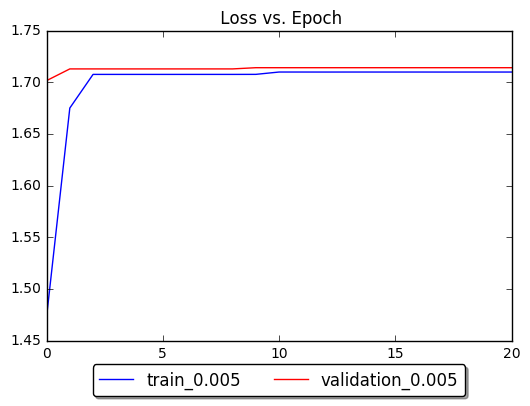

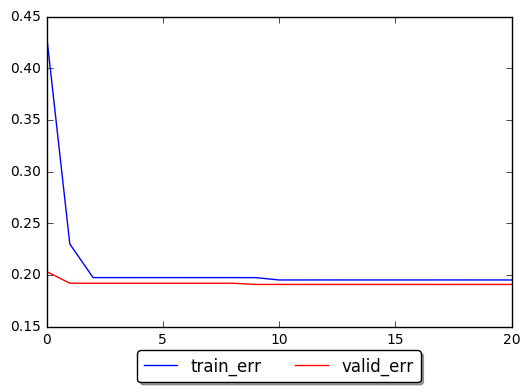

Max Train Error= 0.4320525326357179 Max Validation Error= 0.20328381657600403


In [21]:
#Hyperparameters
learning_rate = 0.005
batch_size = 20
n_epoch = 1000
max_no_progress = 20

train_loss, train_err, valid_loss, valid_err = part1_train(n_epoch,learning_rate,batch_size,max_no_progress)

import matplotlib.pyplot as p 
#proving learning rate 0.005. is the best
p.plot(train_loss,'b-', label="train_0.005")
p.plot(valid_loss,'r-',label ="validation_0.005")
p.title(" Loss vs. Epoch")
p.legend(numpoints=1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

p.plot(train_err,'b-', label="train_err")
p.plot(valid_err,'r-',label ="valid_err")
p.legend(numpoints = 1,loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
p.show()

print("Max Train Error=",np.max(train_err),"Max Validation Error=",np.max(valid_err))

In [18]:
train_loss

array([1.43197554, 1.5851246 , 1.6020421 , 1.71566969, 1.71566176,
       1.71567761, 1.71566969, 1.71566968, 1.71568157, 1.71568554,
       1.7156578 , 1.71566969, 1.71568157, 1.71568157, 1.71567761,
       1.71567365, 1.71568554, 1.71567761, 1.71568554, 1.71568158,
       1.71567761])

In [19]:
valid_loss

array([1.48341894, 1.54987454, 1.69569135, 1.69569135, 1.69569135,
       1.69569135, 1.69569135, 1.69569135, 1.69569135, 1.69569135,
       1.69569135, 1.69569135, 1.69569135, 1.69569135, 1.69569135,
       1.69569135, 1.69569135, 1.69569135, 1.69569135, 1.69569135,
       1.69569135])